<a href="https://colab.research.google.com/github/FleaBusyBeeBergs/dtsa5511-final-project/blob/main/dtsa5511_final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Bank of Canada interest rate changes
DTSA5511 final project


In [1]:
!pip install scikit-learn-intelex -q
#!pip install statsmodels==0.14.0 -q
!pip install tslearn -q
!pip install scikeras -q
!pip install xgboost lightgbm catboost imbalanced-learn -q

In [44]:
# file handling & general
import itertools
import numpy as np
import pandas as pd
import os
from google.colab import files
import xml.etree.ElementTree as ET
import warnings
warnings.filterwarnings('ignore',
                        message = '''.*'force_all_finite' was renamed to 'ensure_all_finite'.*''')
from google.colab import files
from functools import reduce

# http requests
import requests

# vis
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import altair as alt
import seaborn as sns

# ml
from sklearn.preprocessing import MinMaxScaler

## 1 Introduction

This project was first created for dtsa 5506, data mining pipeling project. It initially compared a few supervised models and some unsupervised/clustering models, with a brief attempt at a neural network. This updated version of this project is to use deep learning to predict Bank of Canada interest rate changes before they are announced. Interest rates affect nearly everyone and changes to the prevailing rates affect many decisions not just in the long term, but in the short term as well.

The bank of canada exercises counter-inflationary monetary policy by increasing interest to slow inflation, and decreasing interest to allow to avoid recession. To predict changes to the policy interest rate, it would be helpful to first model and predict inflation. The consumer price index is a common measure of inflation, and cpi time series is available from statistics canada.

The use of deep learning is a fairly new tool for central banks in the last decade. Deep learning allows hundreds or even thousands of variables to be used in prediction models.

This project is a classification? Regression? problem that involves time series, so will reuire the use of an LSTM or GRU


### 1.1 The data

The data was mined from the Statistics Canada database using XLM

In [3]:
# base URL for data extraction
base_url = 'https://www150.statcan.gc.ca/t1/wds/sdmx/statcan/rest/vector/'

# namespace mappings for XML parsing
namespaces = {
    "message": 'http://www.sdmx.org/resources/sdmxml/schemas/v2_1/message',
    "generic": 'http://www.sdmx.org/resources/sdmxml/schemas/v2_1/data/generic',
    "common": 'http://www.sdmx.org/resources/sdmxml/schemas/v2_1/common',
}

Some data series are reported daily, other series are reported monthly, quarterly or annually. To address the various reporting periods, I need a method to fill the NA values.

In [6]:
class StatCanETL:
    '''ETL pipeline for StatCan data'''

    def __init__(self, table_df):
        '''Initialize with a dataframe of metadata table'''
        self.table_df = table_df
        self.data_objects = {}

    def extract(self, vector, start_period, end_period):
        '''Extract data from the StatCan API for a given vector, start, and end dates'''
        url = f'{base_url}{vector}?startPeriod={start_period}&endPeriod={end_period}&detail=full'
        response = requests.get(url)

        if response.status_code == 200:
            return response.content
        else:
            raise ValueError(f'Failed to fetch data for vector {vector}. HTTP Status: {response.status_code}')

    def transform(self, xml_content, frequency):
        '''Transform the XML response into a structured DataFrame'''
        root = ET.fromstring(xml_content)
        series = root.find('.//generic:Series', namespaces)
        if series is None:
            raise ValueError('No Series element found in the XML response')

        observations = series.findall('.//generic:Obs', namespaces)
        data = []
        for obs in observations:
            obs_dim = obs.find('.//generic:ObsDimension', namespaces)
            obs_val = obs.find('.//generic:ObsValue', namespaces)
            date = obs_dim.attrib['value']

            # Convert date format
            if frequency == 'quarterly':
                date = self.convert_quarter_to_date(date)
            elif frequency == 'yearly':
                date = date[:4] + '-01'

            data.append({
                'Date': date,
                'Value': float(obs_val.attrib['value']),
            })

        df = pd.DataFrame(data)
        return df

    @staticmethod
    def convert_quarter_to_date(quarter_str):
        '''Convert quarterly date string (YYYY-Qx) to standard YYYY-MM format'''
        try:
            year, quarter = quarter_str.split('-Q')
            quarter_start_month = {
                '1': '01',
                '2': '04',
                '3': '07',
                '4': '10',
            }.get(quarter)
            if quarter_start_month:
                return f'{year}-{quarter_start_month}'
            else:
                raise ValueError(f'Invalid quarter format: {quarter_str}')
        except Exception as e:
            raise ValueError(f'Error converting quarter string {quarter_str}: {e}')

    def load(self, df, name):
        '''Load df into global object with name `name` (e.g., wage, rmpi)'''
        globals()[name] = df
        self.data_objects[name] = df
        print(f'Data for {name} saved to object {name}')

    def run(self):
        '''Run the full ETL pipeline for all variables'''
        for _, row in self.table_df.iterrows():
            print(f'Processing {row["name"]}...')
            try:
                # extract
                xml_content = self.extract(row['vector'], row['start'], row['end'])

                # transform
                df = self.transform(xml_content, row['frequency'])

                # load
                self.load(df, row['name'])
            except Exception as e:
                print(f'Error processing {row["name"]}: {e}')


My data mining project included:
* wages
* raw materials price index
* consumer price index
* rate - target

Add?:

Housing starts 34-10-0156 v52299896

Building permits 34-10-0292 v1675119645 avail > 2018-01 only

Retail trade 20-10-0067 v1446870183

Unemployment rate 14-10-0287 v2062815

Employment rate 14-10-0287 v2062817

Labour force participation rate 14-10-0287 v2062816

GDP all industries 36-10-0434 v65201210

manufacturing Industrial Production index 18-10-0267 v1230996350

manufacturing Capacity utilization rate 16-10-0015 v1707053279

1 trading partner US exchange rate 33-10-0036 v111666248 avail > 2017-01

2 trading partner Chinese renminbi exchange rate 33-10-0036 v111666226 avail > 2017-01

3 trading partner Euro 33-10-0036 v111666227 avail > 2017-01

4 trading partner Japanese yen 33-10-0036 v111666231 avail > 2017-01

S&P TSX composite close 10-10-0125 v122620

# nts: to get the table with vector ids, need to select 'download selected data (for database loading)'

In [7]:
# metadata - define what information to pull from statcan
tables = {
    'name': ['wage', 'rmpi', 'cpi',
             'house_st', 'bldg', 'retail',
             'unemp', 'empl', 'lab_part',
             'gdp', 'mf_ipi', 'mf_cap',
             'us_fx', 'cn_fx', 'eu_fx',
             'jp_fx', 'tsx_cl', 'rate'],
    'tableid': [14100223, 18100268, 18100004,
                34100156, 34100292, 20100067,
                14100287, 14100287, 14100287,
                36100434, 18100267, 16100015,
                33100036, 33100036, 33100036,
                33100036, 10100125, 10100139],
    'tablename': ['employment and average weekly earnings',
                  'raw materials price index, 2010 = 100',
                  'consumer price index, not seas adj, 2002 = 100',
                  'housing starts',
                  'all building permits issued, dollar value',
                  'retail trade',
                  'unemployment rate',
                  'employment rate',
                  'labour force participation rate',
                  'gross domestic product',
                  'manufacturing indust prod idx',
                  'manufacturing capacity util rate',
                  'usd exchange rate',
                  'china renminbi exchange rate',
                  'euro exchange rate',
                  'japan yen exchange',
                  's&p tsx close',
                  'bank rate'],
    'vector': ['v79311153', 'v1230998135', 'v41690973',
               'v52299896', 'v1675119645', 'v1446870183',
               'v2062815', 'v2062817', 'v2062816',
               'v65201210', 'v1230996350', 'v1707053279',
               'v111666248', 'v111666226', 'v111666227',
               'v111666231', 'v122620', 'v39078'],
    'frequency': ['monthly', 'monthly', 'monthly',
                  'monthly', 'monthly', 'monthly',
                  'monthly', 'monthly', 'monthly',
                  'monthly', 'monthly', 'monthly',
                  'daily', 'daily', 'daily',
                  'daily', 'daily', 'daily'],
    'start': ['2001-01', '2001-01', '2001-01',
              '2001-01', '2018-01', '2001-01',
              '2001-01','2001-01', '2001-01',
              '2001-01','2001-01', '2001-01',
              '2017-01-01', '2017-01-01', '2017-01-01',
              '2017-01-01', '2001-01-01', '2001-01-01'], # if using quarterly data like productivity, format as yyyy-Q#
    'end': ['2024-12', '2024-12', '2024-12',
            '2024-12', '2024-12', '2024-12',
            '2024-12', '2024-12', '2024-12',
            '2024-12', '2024-12', '2024-12',
            '2024-12-31', '2024-12-31', '2024-12-31',
            '2024-12-31', '2024-12-31', '2024-12-31']
}

# make df
table_df = pd.DataFrame(tables)

In [8]:
# boc rate announcement dates, incl 2025
url = 'https://raw.githubusercontent.com/FleaBusyBeeBergs/dtsa5506-pipeline/main/data/rate-announcements.csv'
#url = None
rate_announcements = pd.read_csv(url)
rate_announcements.tail(8)

,date
193,2025-01-29
194,2025-03-12
195,2025-04-16
196,2025-06-04
197,2025-07-30
198,2025-09-17
199,2025-10-29
200,2025-12-10


In [32]:
# run ETL pipe
pipeline = StatCanETL(table_df)
pipeline.run()

Processing wage...
Data for wage saved to object wage
Processing rmpi...
Data for rmpi saved to object rmpi
Processing cpi...
Data for cpi saved to object cpi
Processing house_st...
Data for house_st saved to object house_st
Processing bldg...
Data for bldg saved to object bldg
Processing retail...
Data for retail saved to object retail
Processing unemp...
Data for unemp saved to object unemp
Processing empl...
Data for empl saved to object empl
Processing lab_part...
Data for lab_part saved to object lab_part
Processing gdp...
Data for gdp saved to object gdp
Processing mf_ipi...
Data for mf_ipi saved to object mf_ipi
Processing mf_cap...
Data for mf_cap saved to object mf_cap
Processing us_fx...
Data for us_fx saved to object us_fx
Processing cn_fx...
Data for cn_fx saved to object cn_fx
Processing eu_fx...
Data for eu_fx saved to object eu_fx
Processing jp_fx...
Data for jp_fx saved to object jp_fx
Processing tsx_cl...
Data for tsx_cl saved to object tsx_cl
Processing rate...
Data f

In [33]:
# check to see if data loaded correctly
for key, value in pipeline.data_objects.items():
    print(key)
    print(value.head(3), '\n')

wage
      Date   Value
0  2001-01  657.14
1  2001-02  653.59
2  2001-03  655.14 

rmpi
      Date  Value
0  2001-01   65.2
1  2001-02   65.8
2  2001-03   65.5 

cpi
      Date  Value
0  2001-01   96.3
1  2001-02   96.8
2  2001-03   97.1 

house_st
      Date    Value
0  2001-01  141.470
1  2001-02  126.744
2  2001-03  131.271 

bldg
      Date      Value
0  2018-01  8332584.0
1  2018-02  8352147.0
2  2018-03  8420193.0 

retail
      Date    Value
0  2017-01  50138.0
1  2017-02  49903.0
2  2017-03  50350.0 

unemp
      Date  Value
0  2001-01    6.9
1  2001-02    7.0
2  2001-03    7.1 

empl
      Date  Value
0  2001-01   61.4
1  2001-02   61.3
2  2001-03   61.2 

lab_part
      Date  Value
0  2001-01   65.9
1  2001-02   65.9
2  2001-03   66.0 

gdp
      Date      Value
0  2001-01  1434295.0
1  2001-02  1433843.0
2  2001-03  1434685.0 

mf_ipi
      Date  Value
0  2001-01   77.1
1  2001-02   77.5
2  2001-03   77.8 

mf_cap
      Date  Value
0  2017-01   79.6
1  2017-02   79.2
2  2017

In [37]:
# Your variable lists
variables = ['wage', 'rmpi', 'cpi', 'house_st', 'bldg', 'retail',
             'unemp', 'empl', 'lab_part', 'gdp', 'mf_ipi', 'mf_cap',
             'us_fx', 'cn_fx', 'eu_fx', 'jp_fx', 'tsx_cl', 'rate']

daily = ['us_fx', 'cn_fx', 'eu_fx', 'jp_fx', 'tsx_cl']  # Excludes 'rate' since we process it separately

def rename_value_column(vars_list):
    """Rename 'Value' column to the variable name."""
    for var in vars_list:
        df = globals()[var]
        df.rename(columns={'Value': var}, inplace=True)

def convert_daily_to_monthly(daily_vars):
    """Convert daily dataframes to monthly averages."""
    for var in daily_vars:
        df = globals()[var].copy()
        df['Date'] = pd.to_datetime(df['Date'])
        df['Month'] = df['Date'].dt.to_period('M').dt.to_timestamp()
        df_monthly = df.groupby('Month', as_index=False)[var].mean()
        df_monthly.rename(columns={'Month': 'Date'}, inplace=True)
        globals()[var] = df_monthly

def preprocess_rate(rate_df):
    """
    Cleans and transforms daily interest rate DataFrame to monthly,
    applying the new rate to the first day of the month of change.
    """
    rate_df['Date'] = pd.to_datetime(rate_df['Date'])
    rate_df['rate'] = pd.to_numeric(rate_df['rate'], errors='coerce')

    rate_df = rate_df.sort_values('Date')
    rate_df['prev_rate'] = rate_df['rate'].shift(1)
    rate_df['rate_changed'] = rate_df['rate'] != rate_df['prev_rate']
    rate_changes = rate_df[rate_df['rate_changed']].copy()
    rate_changes['Date'] = rate_changes['Date'].dt.to_period('M').dt.to_timestamp()
    rate_changes = rate_changes.groupby('Date')['rate'].last().reset_index()
    monthly_rate_df = rate_changes.set_index('Date').resample('MS').ffill().reset_index()
    return monthly_rate_df

def ensure_date_datetime(vars_list):
    """Ensure all 'Date' columns are datetime dtype."""
    for var in vars_list:
        df = globals()[var]
        df['Date'] = pd.to_datetime(df['Date'])

def merge_on_date(vars_list):
    """Merge all dataframes on 'Date' column using outer join."""
    dfs = [globals()[var] for var in vars_list]
    merged = reduce(lambda left, right: pd.merge(left, right, on='Date', how='outer'), dfs)
    return merged

# --- RUN CLEANING PIPELINE ---

# Step 1: Rename 'Value' columns
rename_value_column(variables)

# Step 2: Convert daily FX and equity series to monthly averages
convert_daily_to_monthly(daily)

# Step 3: Preprocess rate series using custom logic
rate = preprocess_rate(rate)  # This replaces the global 'rate'

# Step 4: Ensure all Date columns are datetime
ensure_date_datetime(variables)

# Step 5: Merge all data on Date
data = merge_on_date(variables)

The interest rate data is published (almost) daily, but only changes at 8 pre-determined dates per year. This will require some extra wrangling to align with the other monthly series. Where there is a rate change, I'll apply changed rate to that entire month, effective on the 1st day, so that rate_df can be aligned with the rate announcement data.

In [38]:
data.head()

,Date,wage,rmpi,cpi,house_st,bldg,retail,unemp,empl,lab_part,gdp,mf_ipi,mf_cap,us_fx,cn_fx,eu_fx,jp_fx,tsx_cl,rate
0,2001-01-01,657.14,65.2,96.3,141.470,NaN,NaN,6.9,61.4,65.9,1434295.0,77.1,NaN,NaN,NaN,NaN,NaN,9321.87,5.75
1,2001-02-01,653.59,65.8,96.8,126.744,NaN,NaN,7.0,61.3,65.9,1433843.0,77.5,NaN,NaN,NaN,NaN,NaN,8078.72,5.75
2,2001-03-01,655.14,65.5,97.1,131.271,NaN,NaN,7.1,61.2,66.0,1434685.0,77.8,NaN,NaN,NaN,NaN,NaN,7608.00,5.25
3,2001-04-01,652.44,65.2,97.8,144.474,NaN,NaN,7.1,61.3,66.0,1433399.0,78.2,NaN,NaN,NaN,NaN,NaN,7946.63,5.00
4,2001-05-01,652.28,65.3,98.6,139.901,NaN,NaN,7.0,61.3,66.0,1439506.0,78.5,NaN,NaN,NaN,NaN,NaN,8161.87,4.75


In [39]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 288 entries, 0 to 287
Data columns (total 19 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      288 non-null    datetime64[ns]
 1   wage      288 non-null    float64       
 2   rmpi      288 non-null    float64       
 3   cpi       288 non-null    float64       
 4   house_st  288 non-null    float64       
 5   bldg      84 non-null     float64       
 6   retail    96 non-null     float64       
 7   unemp     288 non-null    float64       
 8   empl      288 non-null    float64       
 9   lab_part  288 non-null    float64       
 10  gdp       288 non-null    float64       
 11  mf_ipi    288 non-null    float64       
 12  mf_cap    96 non-null     float64       
 13  us_fx     96 non-null     float64       
 14  cn_fx     96 non-null     float64       
 15  eu_fx     96 non-null     float64       
 16  jp_fx     96 non-null     float64       
 17  tsx_cl    273 no

* we have 288 months of data
* retail, mf_cap, and all fx rate series unavailable from stats can before 2017
* building permits series unavailable from stats can before 2018
* tsx_cl only avail from stats can until sept 2023 - need to append .csv from yahoo finance.

In [40]:
# descriptive stats
data.describe()

,Date,wage,rmpi,cpi,house_st,bldg,retail,unemp,empl,lab_part,gdp,mf_ipi,mf_cap,us_fx,cn_fx,eu_fx,jp_fx,tsx_cl,rate
count,288,288.000000,288.000000,288.000000,288.000000,8.400000e+01,96.000000,288.000000,288.000000,288.000000,2.880000e+02,288.000000,96.000000,96.000000,96.000000,96.000000,96.000000,273.000000,288.000000
mean,2012-12-15 17:00:00,911.699514,99.124653,123.738542,191.275632,1.010502e+07,54473.125000,6.979167,61.790625,66.427778,1.836635e+06,94.009722,78.315625,1.063723,0.155155,1.184627,0.008709,13237.792674,2.242188
min,2001-01-01 00:00:00,652.280000,55.300000,96.300000,95.831000,5.947094e+06,37140.000000,4.800000,51.900000,60.100000,1.433233e+06,74.800000,54.600000,0.808430,0.124555,0.943869,0.007325,6180.420000,0.500000
25%,2006-12-24 06:00:00,772.157500,84.075000,109.775000,173.356250,8.432654e+06,52067.250000,6.200000,61.400000,65.800000,1.656228e+06,82.275000,77.000000,0.905187,0.136450,1.037624,0.008217,10868.210000,1.000000
50%,2012-12-16 12:00:00,903.520000,97.050000,122.200000,189.005500,1.002640e+07,55677.000000,7.000000,61.800000,66.300000,1.806828e+06,92.000000,78.650000,0.956121,0.141812,1.094837,0.008684,13361.260000,1.750000
75%,2018-12-08 18:00:00,1009.772500,112.725000,134.225000,209.608000,1.148836e+07,57298.500000,7.500000,62.400000,67.200000,2.042136e+06,99.625000,80.300000,1.342237,0.187767,1.439105,0.009185,15442.680000,3.250000
max,2024-12-01 00:00:00,1291.170000,166.600000,162.100000,290.954000,1.361708e+07,60141.000000,14.200000,63.600000,67.700000,2.285235e+06,132.700000,83.700000,1.424045,0.198483,1.504505,0.010297,21890.160000,5.750000
std,NaN,170.201881,24.301023,17.143681,31.992781,1.696585e+06,3517.723305,1.169822,1.211767,0.915636,2.395457e+05,15.301474,3.703947,0.207937,0.025958,0.189647,0.000681,3776.432942,1.522531


for plotting, data will need to be scaled

In [49]:
numeric_cols = data.columns.drop('Date')

# Apply MinMax scaling
scaler = MinMaxScaler()
scaled_array = scaler.fit_transform(data[numeric_cols])

# Create scaled DataFrame with same column names and original 'Date'
data_minmax_scaled = pd.DataFrame(scaled_array, columns=numeric_cols)
data_minmax_scaled.insert(0, 'Date', data['Date'])  # Add Date column back


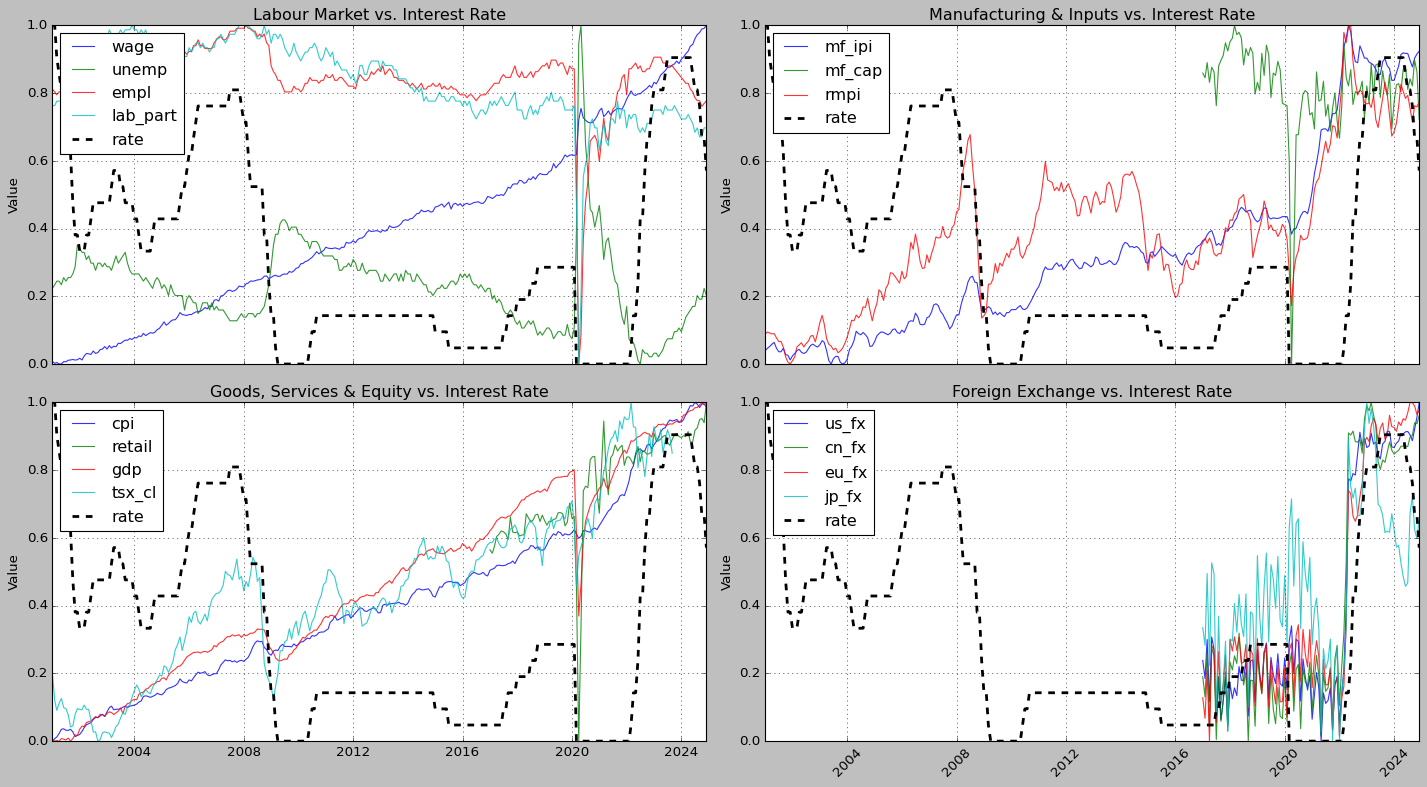

In [50]:
# Set plotting style
plt.style.use('classic')

# Groups of variables
labour_vars = ['wage', 'unemp', 'empl', 'lab_part']
mf_vars     = ['mf_ipi', 'mf_cap', 'rmpi']
gs_vars     = ['cpi', 'retail', 'gdp', 'tsx_cl']
fx_vars     = ['us_fx', 'cn_fx', 'eu_fx', 'jp_fx']
groups = {
    'Labour Market': labour_vars,
    'Manufacturing & Inputs': mf_vars,
    'Goods, Services & Equity': gs_vars,
    'Foreign Exchange': fx_vars
}

# Plot each group with 'rate'
fig, axes = plt.subplots(2, 2, figsize=(18, 10), sharex=True)
axes = axes.flatten()

for i, (title, vars_) in enumerate(groups.items()):
    ax = axes[i]

    # Plot each variable in the group
    for var in vars_:
        ax.plot(data_minmax_scaled['Date'], data_minmax_scaled[var], label=var, alpha=0.8)

    # Plot 'rate' on the same axis (or use a twin axis if needed)
    ax.plot(data_minmax_scaled['Date'], data_minmax_scaled['rate'], label='rate', color='black', linewidth=2.5, linestyle='--')

    ax.set_title(f'{title} vs. Interest Rate')
    ax.set_ylabel('Value')
    ax.legend(loc='upper left')
    ax.grid(True)

# Format x-axis labels
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()